# MO-D2NN条件振り
## まずは層数を固定したまま

In [32]:
! rm -rd MOD2NN
! git clone https://$$TOKEN@github.com/konnitiha3/MOD2NN.git

Cloning into 'MOD2NN'...
remote: Enumerating objects: 1538, done.
remote: Counting objects: 100% (303/303), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 1538 (delta 166), reused 217 (delta 104), pack-reused 1235:   4% (62/1538), 3.66 MiB | 2.35 MiB/sReceiving objects:   6% (93/1538), 4.89 MiB | 2.37 MiB/sReceiving objects:   8% (124/1538), 4.89 MiB | 2.37 MiB/sReceiving objects:  10% (154/1538), 6.45 MiB | 2.52 MiB/sReceiving objects:  11% (183/1538), 6.45 MiB | 2.52 MiB/sReceiving objects:  13% (200/1538), 7.82 MiB | 2.55 MiB/sReceiving objects:  17% (262/1538), 7.82 MiB | 2.55 MiB/sReceiving objects:  19% (293/1538), 7.82 MiB | 2.55 MiB/sReceiving objects:  21% (323/1538), 8.90 MiB | 2.48 MiB/sReceiving objects:  23% (357/1538), 8.90 MiB | 2.48 MiB/sReceiving objects:  25% (385/1538), 9.52 MiB | 2.32 MiB/sReceiving objects:  27% (416/1538), 9.52 MiB | 2.32 MiB/sReceiving objects:  29% (447/1538), 10.96 MiB | 2.35 MiB/sReceiving objects:  32% (493/1538), 13.2

In [1]:
import sys
sys.path.append('/notebooks/MOD2NN')

In [3]:
import time
import sys
import os
import json

import tensorflow as tf
import pandas as pd
from Faraday.two_dim.module.lib.layers import *

from Faraday.two_dim import matplotlib_style
matplotlib_style.paper()
tf.random.set_seed(1)

print("TensorFlow:", tf.__version__)
print("Python:", sys.version)

plt.rcParams['font.size'] = 18

TensorFlow: 2.9.1
Python: 3.9.13 (main, May 23 2022, 22:01:06) 
[GCC 9.4.0]


In [5]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

In [6]:
#@title デフォルトのタイトル テキスト
wavelength = 633.0e-9 #@param {type:"number"}
d = 1.0e-6 #@param {type:"number"}
n = 1.5 #@param {type:"number"}
z = 0.7e-3 #@param {type:"number"}

In [53]:
def create_model(**kwargs):
    shape = (100, 100)
    theta = kwargs["theta"]
    eta = 0.
    tf.random.set_seed(kwargs["seed"])
    inputs = tf.keras.Input((28, 28))
    x = ImageResizing(shape)(inputs)
    x = IntensityToElectricField(shape)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = FaradayRotationByStokes(shape)(x)
    x = MNISTDetector(shape)(x)
    x = tf.keras.layers.Softmax()(x)
    model = tf.keras.Model(inputs, x)
    return model

In [60]:
def train(seed, theta):
    model_name = "20221129/maxnorm/theta_pi{:d}_seed_{:d}".format(int(np.round(np.pi/theta)), seed)
    path = "/notebooks/"
    checkpoint_path = "checkpoint/" + model_name + "/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    path = path + "trained_model/"+ model_name

    model = create_model(seed=seed, theta=theta)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,  # category: sparse_categorical_crossentropy
                  metrics=["accuracy"]
                  )

    epochs = 30

    # チェックポイントコールバックを作る
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    logdir = os.path.join(path +"logs", model_name)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    result = model.fit(x_train,
                       y_train,
                       batch_size=64,
                       epochs=epochs,
                       validation_data=(x_val, y_val),
                       callbacks=[cp_callback, tensorboard_callback]
                       )

    model.save(path)

    df = pd.DataFrame(result.history)
    df.to_csv(path + "/history.csv")



    with open(path + "/config.json", 'w') as f:
        json.dump(model.get_config(), f, indent=4)

In [ ]:
list = [np.pi/100., np.pi/500., np.pi/1000.]
for theta in list:
    for i in range(5):
        train(seed=i+1, theta=theta)

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_18 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _18 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 angular_spectrum_108 (Angul  (None, 2, 100, 100)      0         
 arSpectrum)                                                     
                                                                 
 mo_90 (MO)                  (None, 2, 100, 100)       100

INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi100_seed_1/assets


INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi100_seed_1/assets


Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_19 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _19 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 angular_spectrum_114 (Angul  (None, 2, 100, 100)      0         
 arSpectrum)                                                     
                                                                 
 mo_95 (MO)                  (None, 2, 100, 100)       100

INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi100_seed_2/assets


INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi100_seed_2/assets


Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_20 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _20 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 angular_spectrum_120 (Angul  (None, 2, 100, 100)      0         
 arSpectrum)                                                     
                                                                 
 mo_100 (MO)                 (None, 2, 100, 100)       100

INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi100_seed_3/assets


INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi100_seed_3/assets


Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_21 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _21 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 angular_spectrum_126 (Angul  (None, 2, 100, 100)      0         
 arSpectrum)                                                     
                                                                 
 mo_105 (MO)                 (None, 2, 100, 100)       100

INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi100_seed_4/assets


INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi100_seed_4/assets


Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_22 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _22 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 angular_spectrum_132 (Angul  (None, 2, 100, 100)      0         
 arSpectrum)                                                     
                                                                 
 mo_110 (MO)                 (None, 2, 100, 100)       100

INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi100_seed_5/assets


INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi100_seed_5/assets


Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_23 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _23 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 angular_spectrum_138 (Angul  (None, 2, 100, 100)      0         
 arSpectrum)                                                     
                                                                 
 mo_115 (MO)                 (None, 2, 100, 100)       100

INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi500_seed_1/assets


INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi500_seed_1/assets


Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_24 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _24 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 angular_spectrum_144 (Angul  (None, 2, 100, 100)      0         
 arSpectrum)                                                     
                                                                 
 mo_120 (MO)                 (None, 2, 100, 100)       100

INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi500_seed_2/assets


INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi500_seed_2/assets


Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_25 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _25 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 angular_spectrum_150 (Angul  (None, 2, 100, 100)      0         
 arSpectrum)                                                     
                                                                 
 mo_125 (MO)                 (None, 2, 100, 100)       100

INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi500_seed_3/assets


INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi500_seed_3/assets


Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_26 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _26 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 angular_spectrum_156 (Angul  (None, 2, 100, 100)      0         
 arSpectrum)                                                     
                                                                 
 mo_130 (MO)                 (None, 2, 100, 100)       100

INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi500_seed_4/assets


INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi500_seed_4/assets


Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_27 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _27 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 angular_spectrum_162 (Angul  (None, 2, 100, 100)      0         
 arSpectrum)                                                     
                                                                 
 mo_135 (MO)                 (None, 2, 100, 100)       100

INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi500_seed_5/assets


INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi500_seed_5/assets


Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_28 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _28 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 angular_spectrum_168 (Angul  (None, 2, 100, 100)      0         
 arSpectrum)                                                     
                                                                 
 mo_140 (MO)                 (None, 2, 100, 100)       100

INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi1000_seed_1/assets


INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi1000_seed_1/assets


Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_29 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _29 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 angular_spectrum_174 (Angul  (None, 2, 100, 100)      0         
 arSpectrum)                                                     
                                                                 
 mo_145 (MO)                 (None, 2, 100, 100)       100

INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi1000_seed_2/assets


INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi1000_seed_2/assets


Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_30 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _30 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 angular_spectrum_180 (Angul  (None, 2, 100, 100)      0         
 arSpectrum)                                                     
                                                                 
 mo_150 (MO)                 (None, 2, 100, 100)       100

INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi1000_seed_3/assets


INFO:tensorflow:Assets written to: /notebooks/trained_model/20221129/maxnorm/theta_pi1000_seed_3/assets


Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_31 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _31 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 angular_spectrum_186 (Angul  (None, 2, 100, 100)      0         
 arSpectrum)                                                     
                                                                 
 mo_155 (MO)                 (None, 2, 100, 100)       100

In [13]:
img14 = tf.image.resize(tf.expand_dims(x_train[0:1,:,:], axis=-1), (14, 14))
img28 = tf.image.resize(tf.expand_dims(x_train[0:1,:,:], axis=-1), (28, 28))
img56 = tf.image.resize(tf.expand_dims(x_train[0:1,:,:], axis=-1), (56, 56))
img84 = tf.image.resize(tf.expand_dims(x_train[0:1,:,:], axis=-1), (84, 84))

In [9]:
import matplotlib.pyplot as plt

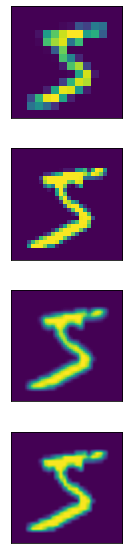

In [19]:
fig, axes = plt.subplots(4, 1, figsize=(2,10))

axes[0].imshow(img14[0,:,:,0])
axes[1].imshow(img28[0,:,:,0])
axes[2].imshow(img56[0,:,:,0])
axes[3].imshow(img84[0,:,:,0])

for ax in axes:
    ax.set_xticks([],[])
    ax.set_yticks([],[])